<h1 style="text-align:center;">Practical session 12</h1>
<h2 style="text-align:center;">Biomedical Data Science</h2>
<h3 style="text-align:center;">Lucas Fayolle & Jose Valero</h3>

# Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Generals
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Feature extraction
from sklearn.feature_selection import VarianceThreshold

from boruta import BorutaPy
from sklearn.inspection import permutation_importance

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

# Classification models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Data

The first step is to load the dataset `data.csv`, which was generated by the `extract_features.ipynb` notebook. This file contains radiomic features combined with diagnostic predictions of tumor types (HGG for High-Grade Glioma and LGG for Low-Grade Glioma). 

To create the file, the process involves dynamically generating headers for the radiomic features (`C1`, `C2`, etc.) along with a column for the tumor type (`tumor_type`). Each sample in `samples` is augmented with its corresponding diagnostic label from `diagnostic`, producing a complete dataset where features and labels are aligned row by row.

In [3]:
df = pd.read_csv("data.csv")

In [4]:
df

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C92,C93,C94,C95,C96,C97,C98,C99,C100,tumor_type
0,174.0,650.0,2.588828e+09,4.300822,324.0,2.196185,1085.0,357.892864,169.490477,256.0,...,39.115214,35.693137,39.874804,15651.083333,29.130457,0.795019,3806.004555,0.243178,15709.0,HGG
1,427.0,826.0,1.555094e+09,4.670797,229.5,2.685919,1077.0,626.103994,128.342289,632.0,...,23.769729,24.413111,27.000000,3703.416667,18.059959,0.727742,1590.651380,0.429509,3731.0,HGG
2,212.0,697.0,6.472778e+09,4.796344,283.0,2.510939,1170.0,459.821288,154.048324,457.0,...,46.238512,44.944410,46.914816,26368.250000,37.044511,0.752399,5694.078769,0.215945,26400.0,HGG
3,429.9,856.0,6.238777e+09,4.777974,210.0,4.546907,1463.0,633.593407,134.813886,612.0,...,36.055513,54.626001,64.327288,14306.666667,26.111726,0.597259,4771.779131,0.333535,14410.0,HGG
4,358.0,649.0,1.212578e+10,4.199889,143.0,3.011379,1056.0,508.111091,88.454307,511.0,...,57.706152,59.774577,60.646517,44537.541667,43.406304,0.634706,9573.316675,0.214949,44774.0,HGG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,3754.0,7206.9,1.021032e+12,7.652972,1937.0,2.885087,11777.0,5592.867096,1065.960253,5670.0,...,49.040799,41.146081,53.972215,30850.416667,32.945548,0.717464,6630.174444,0.214914,30932.0,HGG
355,648.0,1422.0,2.668548e+10,5.384028,463.0,3.096456,2749.0,993.503008,246.611399,972.0,...,66.910388,67.268120,69.778220,24684.666667,31.414140,0.597705,6859.333413,0.277878,24765.0,HGG
356,2250.2,5166.0,2.305284e+11,7.453490,1575.5,2.531188,7216.0,3680.912932,891.534753,3644.0,...,46.957428,41.303753,47.686476,15592.375000,26.732679,0.693717,4350.875982,0.279039,15643.0,HGG
357,1652.0,5113.0,6.660589e+11,7.591514,2107.0,2.602830,8575.0,3346.971976,1086.213192,3359.0,...,54.083269,51.039201,56.142675,51393.333333,41.408206,0.820776,8144.490174,0.158474,51455.0,HGG


# Feature extraction

Feature extraction is a critical step in the radiomics pipeline, as it involves selecting the most relevant variables from the dataset since usually these datasets contain a large number of radiomic features. In our case, we have 100 radiomic features derived from medical imaging, along with a target column indicating tumor type (HGG or LGG). These features describe characteristics such as texture, intensity, and shape, but not all of them contribute equally to the predictive task. Many are highly correlated or may contain noise, making feature extraction essential to streamline the dataset and improve model performance.

### Why is Feature Extraction Important?

Having 100 radiomic features introduces challenges such as multicollinearity, redundancy, and overfitting. Including all features without filtering risks overwhelming machine learning models and reducing interpretability. Feature extraction addresses these issues by:
1. Reducing dimensionality, allowing models to focus on the most informative features while improving computational efficiency.
2. Managing multicollinearity by identifying clusters of correlated features and selecting representative ones.
3. Enhancing reproducibility and robustness by removing features with low variability or those sensitive to noise.

### Workflow for Feature Selection

The workflow for feature extraction in this pipeline is structured as follows:
1. **Analysis of Feature Reproducibility**: Variance-based thresholds are applied to exclude features with minimal variability, as these are unlikely to contribute meaningful information.
2. **Feature Importance Assessment**: The Boruta algorithm is employed to rank features based on their relevance to the predictive task, reducing the feature space to include only those most associated with the target variable.
3. **Visualization**: Correlation heatmaps are generated to provide insights into feature interrelationships.
4. **Clustering and Feature Selection**: Clustering techniques group correlated features, and representative features are selected from each cluster to minimize redundancy while preserving information.
5. **Final Selection**: A concise set of features (typically three to ten) is chosen for model fitting.

## Step 1: Reproducibility analysis

This step removes features with low variance, which are unlikely to contribute meaningful information to the model. Features with minimal variability across samples are often redundant or noisy, adding little to the predictive task. By applying a variance threshold, we ensure that only features with sufficient variability are retained. 

The function uses `VarianceThreshold`, a key method for filtering out low-variance features, and returns the reduced feature matrix along with the names of the selected features.

In [5]:
def apply_variance_threshold(df, target_col, threshold=0.01):
    selector = VarianceThreshold(threshold=threshold)
    df_features = selector.fit_transform(df.drop(columns=[target_col]))
    selected_columns = df.drop(columns=[target_col]).columns[selector.get_support()]
    
    return df_features, selected_columns

In [6]:
df_features, selected_columns_after_variance = apply_variance_threshold(df, "tumor_type")

In [7]:
print(f"Number of features retained after applying variance threshold: {len(selected_columns_after_variance)}")
print(f"Selected features: {selected_columns_after_variance}")

Number of features retained after applying variance threshold: 89
Selected features: Index(['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21',
       'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C34', 'C35',
       'C36', 'C37', 'C38', 'C39', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45',
       'C46', 'C47', 'C48', 'C49', 'C50', 'C52', 'C53', 'C55', 'C56', 'C57',
       'C58', 'C59', 'C60', 'C61', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68',
       'C69', 'C71', 'C73', 'C74', 'C75', 'C76', 'C77', 'C79', 'C80', 'C81',
       'C82', 'C84', 'C85', 'C86', 'C87', 'C88', 'C89', 'C90', 'C91', 'C92',
       'C93', 'C94', 'C95', 'C96', 'C97', 'C98', 'C99', 'C100'],
      dtype='object')


After applying this function, we retain 89 features, having removed all features with variance below the specified threshold.

## Step 2:  Feature Importance Assessment

This step focuses on identifying the most relevant features for the predictive task using the Boruta algorithm, with the flexibility to choose among different ensemble models such as `RandomForestClassifier`, `GradientBoostingClassifier`, or `ExtraTreesClassifier`. Each model leverages the `n_estimators` parameter to define the number of trees in the ensemble, providing robust estimates of feature importance.

- **Key Functionality**:
  1. A user-specified model name determines which ensemble method (e.g., Random Forest) to use as the base estimator.
  2. The Boruta algorithm (`BorutaPy`) evaluates each feature's importance by comparing it to random shadow features, ensuring only genuinely important variables are retained.

- **Output**: The function returns a list of `selected_features`, which includes only the most relevant variables identified by Boruta for the selected model.

In [8]:
def apply_boruta(df_features, target, selected_columns, model_name="RandomForest", n_estimators=100, random_state=42):
    models = {
        "RandomForest": RandomForestClassifier(n_estimators=n_estimators, random_state=random_state),
        "GradientBoosting": GradientBoostingClassifier(n_estimators=n_estimators, random_state=random_state),
        "ExtraTrees": ExtraTreesClassifier(n_estimators=n_estimators, random_state=random_state),
    }
    
    if model_name not in models:
        raise ValueError(
            f"Model '{model_name}' is not supported by Boruta. "
        )
    
    model = models[model_name]
    
    boruta_selector = BorutaPy(model, n_estimators='auto', random_state=random_state)
    boruta_selector.fit(df_features, df[target])
    selected_features = selected_columns[boruta_selector.support_]
    
    return selected_features

In [9]:
selected_features = apply_boruta(df_features, "tumor_type", selected_columns_after_variance)

In [21]:
print(f"Number of features retained after applying Boruta: {len(selected_features)}")
print(f"Selected features: {selected_features}")

Number of features retained after applying Boruta: 21
Selected features: Index(['C1', 'C6', 'C7', 'C12', 'C15', 'C23', 'C24', 'C25', 'C26', 'C27',
       'C45', 'C49', 'C60', 'C64', 'C71', 'C76', 'C95', 'C96', 'C97', 'C98',
       'C100'],
      dtype='object')


After applying this function, we retain 21 features, having removed those deemed irrelevant or redundant by the Boruta algorithm.

## Step 3: Data visualization

This step focuses on visualizing the relationships between the selected features through a correlation heatmap and a dendrogram. These visualizations provide insights into feature redundancy and clustering, enabling informed decisions about selecting representative variables for the next stages

The correlation heatmap is created by computing a correlation matrix for the selected features, where the color intensity represents the strength of linear relationships between pairs of variables. This helps identify clusters of features that may carry redundant information. 

To complement this, a hierarchical clustering is performed on the correlation matrix using the Ward linkage method. This approach groups features into clusters based on their similarities. The resulting dendrogram provides a structured view of how features are related, making it easier to select representative variables from each cluster for downstream analysis.

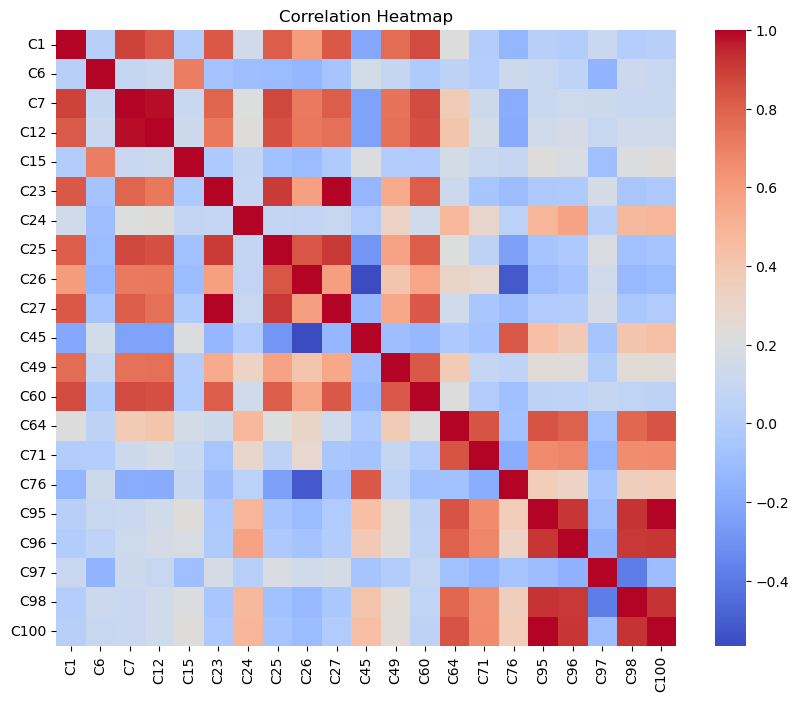

In [22]:
correlation_matrix = df[selected_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

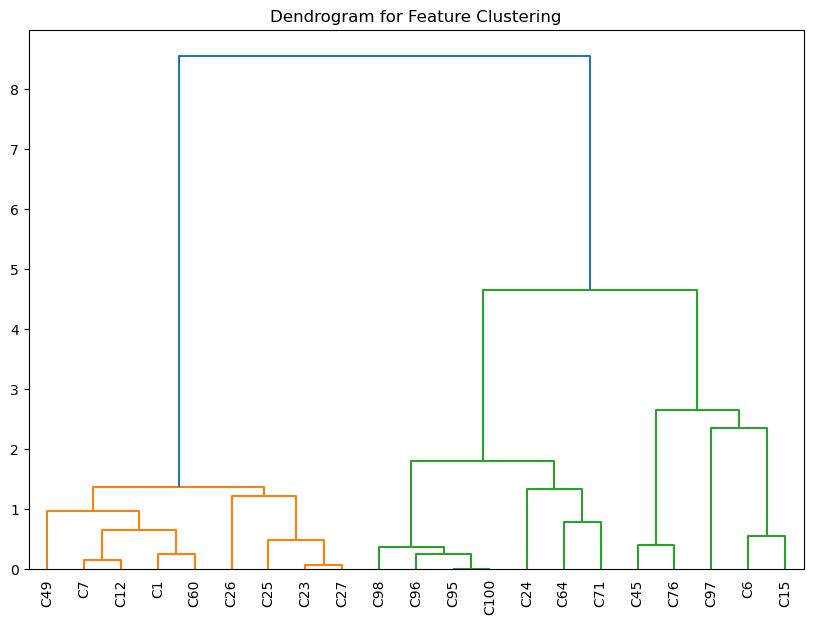

In [23]:
linkage_matrix = linkage(correlation_matrix, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=selected_features, leaf_rotation=90)
plt.title("Dendrogram for Feature Clustering")
plt.show()

## Step 4: Clustering and Selection of Representative Features

This step uses hierarchical clustering to group correlated features and selects a single representative feature from each cluster. The goal is to reduce redundancy while preserving the most informative variables for the predictive task.

The function first calculates a distance matrix based on the absolute values of feature correlations, as lower correlations indicate greater distances. Hierarchical clustering is then applied using the Ward linkage method, grouping features into `num_clusters` clusters. For each cluster, the feature most correlated with the rest of the features in that cluster is selected as the representative.

This approach ensures that the dataset is streamlined by retaining only the most relevant features from each group of highly correlated variables. The output is a list of `representative_features`, which includes one feature per cluster.

In [12]:
def cluster_and_select_representative_features(correlation_matrix, num_clusters):
    distance_matrix = 1 - np.abs(correlation_matrix)
    linkage_matrix = linkage(squareform(distance_matrix, checks=False), method='ward')
    
    clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
    
    cluster_df = pd.DataFrame({
        "Feature": correlation_matrix.columns,
        "Cluster": clusters
    })
    
    representative_features = []
    for cluster_id in cluster_df["Cluster"].unique():
        cluster_features = cluster_df.loc[cluster_df["Cluster"] == cluster_id, "Feature"].values
        cluster_corr = correlation_matrix.loc[cluster_features, cluster_features].mean(axis=1)
        representative = cluster_corr.idxmax()
        representative_features.append(representative)
    
    return representative_features

In [16]:
representative_features = cluster_and_select_representative_features(
    correlation_matrix=correlation_matrix,
    num_clusters=9
)

In [56]:
print(f"Number of representative features: {len(representative_features)}")
print(f"Representative features selected from clusters: {representative_features}")

Number of representative features: 9
Representative features selected from clusters: ['C7', 'C6', 'C27', 'C24', 'C26', 'C45', 'C64', 'C100', 'C97']


# Model Training and Evaluation

This function trains a machine learning model on the selected features and evaluates its performance using the macro F1-score. The function also supports optional printing of the classification report to provide more detailed metrics.

- **Key Steps**:
  1. **Data Splitting**: The dataset is split into training and testing sets, with 80% of the data used for training and 20% reserved for testing.
  2. **Model Training**: The specified model is trained using the training data (`X_train` and `y_train`), fitting it to the selected features.
  3. **Prediction**: The trained model predicts the target labels for the test set (`X_test`), and the predictions are compared to the true labels (`y_test`).
  4. **Performance Metric**: The macro F1-score is calculated to assess the model’s performance across all classes.
  5. **Optional Report**: If `imprimir=True`, the function prints a detailed classification report, including metrics like precision, recall, and F1-score for each class.

- **Output**: The function returns the macro F1-score, providing a single, interpretable metric to compare the performance of different models or feature sets.

In [76]:
def train_and_evaluate_model(df, features, target_col, model, imprimir=False):
    X_train, X_test, y_train, y_test = train_test_split(
        df[features], df[target_col], test_size=0.2, random_state=42
    )
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    
    if imprimir:
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
    
    return macro_f1

Using the selected representative features and the `RandomForestClassifier`, the model was trained and evaluated on the dataset. The following classification report summarizes the results:

In [77]:
rf_model = RandomForestClassifier(random_state=42)

macro_f1_score = train_and_evaluate_model(
    df=df,
    features=representative_features,
    target_col="tumor_type",
    model=rf_model,
    imprimir=True
)

Classification Report:
              precision    recall  f1-score   support

         HGG       0.92      0.95      0.93        58
         LGG       0.75      0.64      0.69        14

    accuracy                           0.89        72
   macro avg       0.83      0.80      0.81        72
weighted avg       0.88      0.89      0.89        72



Some comments on the performance of the model:

- The model achieves a high F1-score of **0.93** for the HGG class, indicating strong performance for this majority class.
- For the LGG class, which is underrepresented in the dataset, the F1-score drops to **0.69**, reflecting the challenges of handling class imbalance.
- The **macro average F1-score** is **0.81**, which provides a balanced view of the model's performance across both classes, regardless of their support.

# Extra: Optimization process

## Main function

The `optimize_and_evaluate` function automates the process of feature selection, clustering, and model evaluation by exploring multiple configurations. It systematically tests various Boruta models, numbers of feature clusters, and classification models to identify the combination that maximizes the macro F1-score. Additionally, it saves the full classification report for each configuration, providing detailed insights into the performance of the models.

The main parameters of the function include:
- `num_clusters_range`, which defines the range of cluster counts to evaluate during feature grouping.
- `boruta_models`, specifying the models used for feature selection, such as Random Forest or Gradient Boosting.
- `classifier_models`, listing the classifiers used for prediction, such as Logistic Regression, SVM, or Decision Tree.

The output is a DataFrame summarizing the results of all tested configurations. Each row contains:
- The Boruta model used for feature selection.
- The classifier model applied for prediction.
- The number of clusters for feature grouping.
- The macro F1-score, which evaluates the overall model performance.
- The full classification report, offering detailed metrics like precision, recall, and F1-score for each class.

This comprehensive output enables both quantitative and qualitative assessment of the tested pipelines, facilitating the selection of the best-performing configuration for the dataset.

In [74]:
def optimize_and_evaluate(
    df, 
    target_col="tumor_type", 
    num_clusters_range=range(3, 11), 
    boruta_models=None, 
    classifier_models=None
):
    if boruta_models is None:
        boruta_models = {
            "RandomForest": RandomForestClassifier(random_state=42),
            "GradientBoosting": GradientBoostingClassifier(random_state=42),
            "ExtraTrees": ExtraTreesClassifier(random_state=42),
        }
    
    if classifier_models is None:
        classifier_models = {
            "RandomForest": RandomForestClassifier(random_state=42),
            "GradientBoosting": GradientBoostingClassifier(random_state=42),
            "ExtraTrees": ExtraTreesClassifier(random_state=42),
            "DecisionTree": DecisionTreeClassifier(random_state=42),
            "LogisticRegression": LogisticRegression(random_state=42, max_iter=500),
            "SVM": SVC(random_state=42),
            "KNN": KNeighborsClassifier()
        }

    results = []

    df_features, selected_columns_after_variance = apply_variance_threshold(df, target_col, threshold=0.01)
    
    for boruta_model_name, boruta_model in boruta_models.items():
        selected_features = apply_boruta(df_features, target_col, selected_columns_after_variance, 
                                         model_name=boruta_model_name)
        selected_data = df[selected_features]
        correlation_matrix = selected_data.corr()
        
        for num_clusters in num_clusters_range:
            representative_features = cluster_and_select_representative_features(correlation_matrix, num_clusters)
            
            for classifier_model_name, classifier_model in classifier_models.items():
                X_train, X_test, y_train, y_test = train_test_split(
                    df[representative_features], df[target_col], test_size=0.2, random_state=42
                )
                classifier_model.fit(X_train, y_train)
                y_pred = classifier_model.predict(X_test)
                
                macro_f1 = f1_score(y_test, y_pred, average="macro")
                report = classification_report(y_test, y_pred, output_dict=False)  # Save full report
                
                results.append({
                    "Boruta_Model": boruta_model_name,
                    "Classifier_Model": classifier_model_name,
                    "Num_Clusters": num_clusters,
                    "Macro_F1_Score": macro_f1,
                    "Classification_Report": report
                })
    
    results_df = pd.DataFrame(results)
    return results_df

In [75]:
df_results = optimize_and_evaluate(df)

In [78]:
# df_results.to_csv("results_experiments.csv")

## Some analysis

To analyze the outcomes of the optimization process, several visualizations have been created. These graphs provide insights into how different configurations impact the model's performance, focusing on the macro F1-score:

1. **Macro F1-Score by Classifier Model**: This bar chart compares the average macro F1-scores achieved by each classifier. It highlights which classification models perform best overall, providing guidance on the most effective choices.

2. **Macro F1-Score by Boruta Model**: This visualization focuses on the Boruta models used for feature selection, showing the average macro F1-scores for each. It helps determine which feature selection approach contributes the most to model performance.

3. **Macro F1-Score by Model Combination**: A detailed comparison of the combined Boruta and classifier models. The chart displays the macro F1-scores for each pairing, offering insights into the interplay between feature selection and classification methods.

4. **Impact of Number of Clusters on Macro F1-Score**: This line plot illustrates the relationship between the number of feature clusters and the macro F1-score. It helps identify the optimal number of clusters for balancing model simplicity and performance.

In [79]:
df_results = pd.read_csv("results_experiments.csv")

In [44]:
def plot_f1_score_by_model(results_df):
    sorted_df = results_df.groupby("Classifier_Model")["Macro_F1_Score"].mean().sort_values(ascending=False).reset_index()
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=sorted_df, x="Classifier_Model", y="Macro_F1_Score", ci=None, palette="viridis")
    plt.title("Macro F1-Score by Classifier_Model", fontsize=16)
    plt.ylabel("Macro F1-Score", fontsize=14)
    plt.xlabel("Model", fontsize=14)
    plt.ylim(0, 1)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

In the following graph, the macro F1-scores achieved by different classifier models are compared. **RandomForest** demonstrates the highest macro F1-score, highlighting its ability to effectively handle both classes, even in imbalanced datasets. **GradientBoosting** and **DecisionTree** also perform competitively, with scores close to RandomForest, making them reliable alternatives for the classification task. In contrast, models like **LogisticRegression**, **KNN**, and **SVM** show lower performance. This analysis indicates that tree-based models, especially RandomForest, are better suited for this dataset, offering robust and balanced classification results.

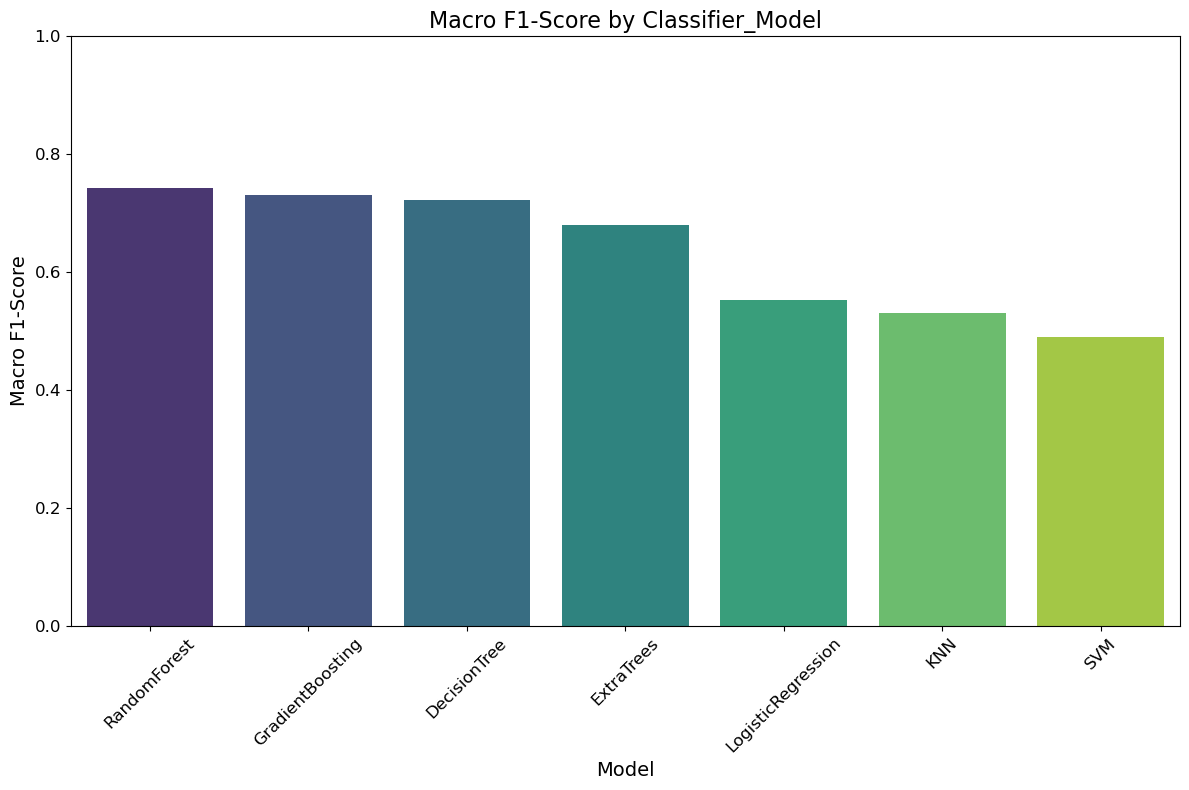

In [45]:
plot_f1_score_by_model(df_results)

In [46]:
def plot_f1_score_by_boruta_model(results_df):
    sorted_df = results_df.groupby("Boruta_Model")["Macro_F1_Score"].mean().sort_values(ascending=False).reset_index()

    plt.figure(figsize=(12, 8))
    sns.barplot(data=sorted_df, x="Boruta_Model", y="Macro_F1_Score", ci=None, palette="coolwarm")
    plt.title("Macro F1-Score by Boruta Model", fontsize=16)
    plt.ylabel("Macro F1-Score", fontsize=14)
    plt.xlabel("Boruta Model", fontsize=14)
    plt.ylim(0, 1)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

In the following graph, the macro F1-scores achieved by the Boruta models used for feature selection are compared. **GradientBoosting** and **RandomForest** perform similarly, with slightly better results than **ExtraTrees**. This suggests that both Gradient Boosting and Random Forest are effective at identifying the most relevant features for the classification task. While ExtraTrees performs slightly worse, it still provides competitive results. Overall, all three models demonstrate robust feature selection capabilities.

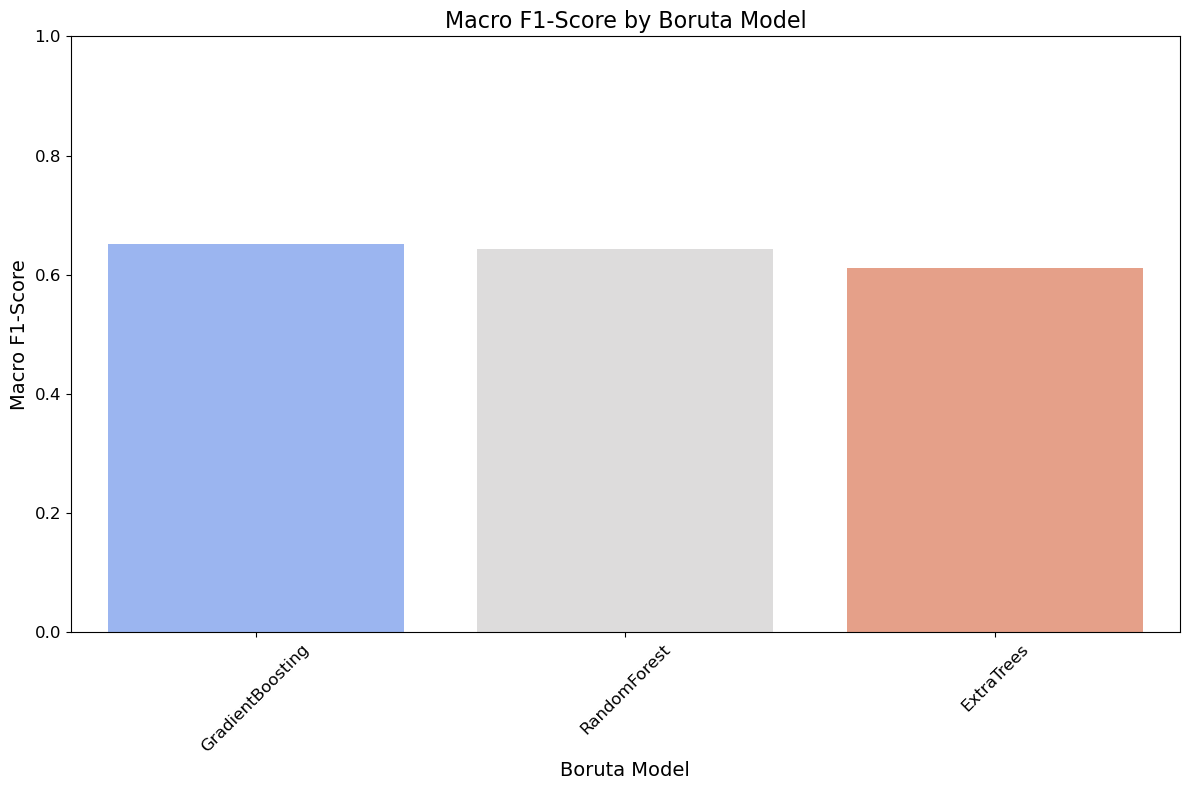

In [47]:
plot_f1_score_by_boruta_model(df_results)

In [48]:
def plot_f1_score_by_combination(results_df):
    results_df["Model_Combination"] = results_df["Boruta_Model"] + " + " + results_df["Classifier_Model"]
    
    sorted_df = results_df.groupby("Model_Combination")["Macro_F1_Score"].mean().sort_values(ascending=False).reset_index()
    
    plt.figure(figsize=(16, 10))
    sns.barplot(data=sorted_df, x="Model_Combination", y="Macro_F1_Score", ci=None, palette="plasma")
    plt.title("Macro F1-Score by Model Combination", fontsize=16)
    plt.ylabel("Macro F1-Score", fontsize=14)
    plt.xlabel("Model Combination (Boruta + Classifier)", fontsize=14)
    plt.ylim(0, 1)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

In the following graph, the macro F1-scores for each combination of Boruta and classifier models are displayed. The top-performing combinations are **GradientBoosting + RandomForest**, **GradientBoosting + GradientBoosting**, and **GradientBoosting + DecisionTree**, which achieve the highest macro F1-scores. These results indicate that GradientBoosting as the feature selection method pairs effectively with tree-based classifiers.

On the other hand, combinations involving **LogisticRegression**, **KNN**, and **SVM** generally perform worse, reflecting their limitations in handling complex feature spaces compared to tree-based models. This analysis highlights that the choice of both feature selection and classifier models plays a significant role in achieving optimal performance, with combinations involving tree-based methods emerging as the most effective.

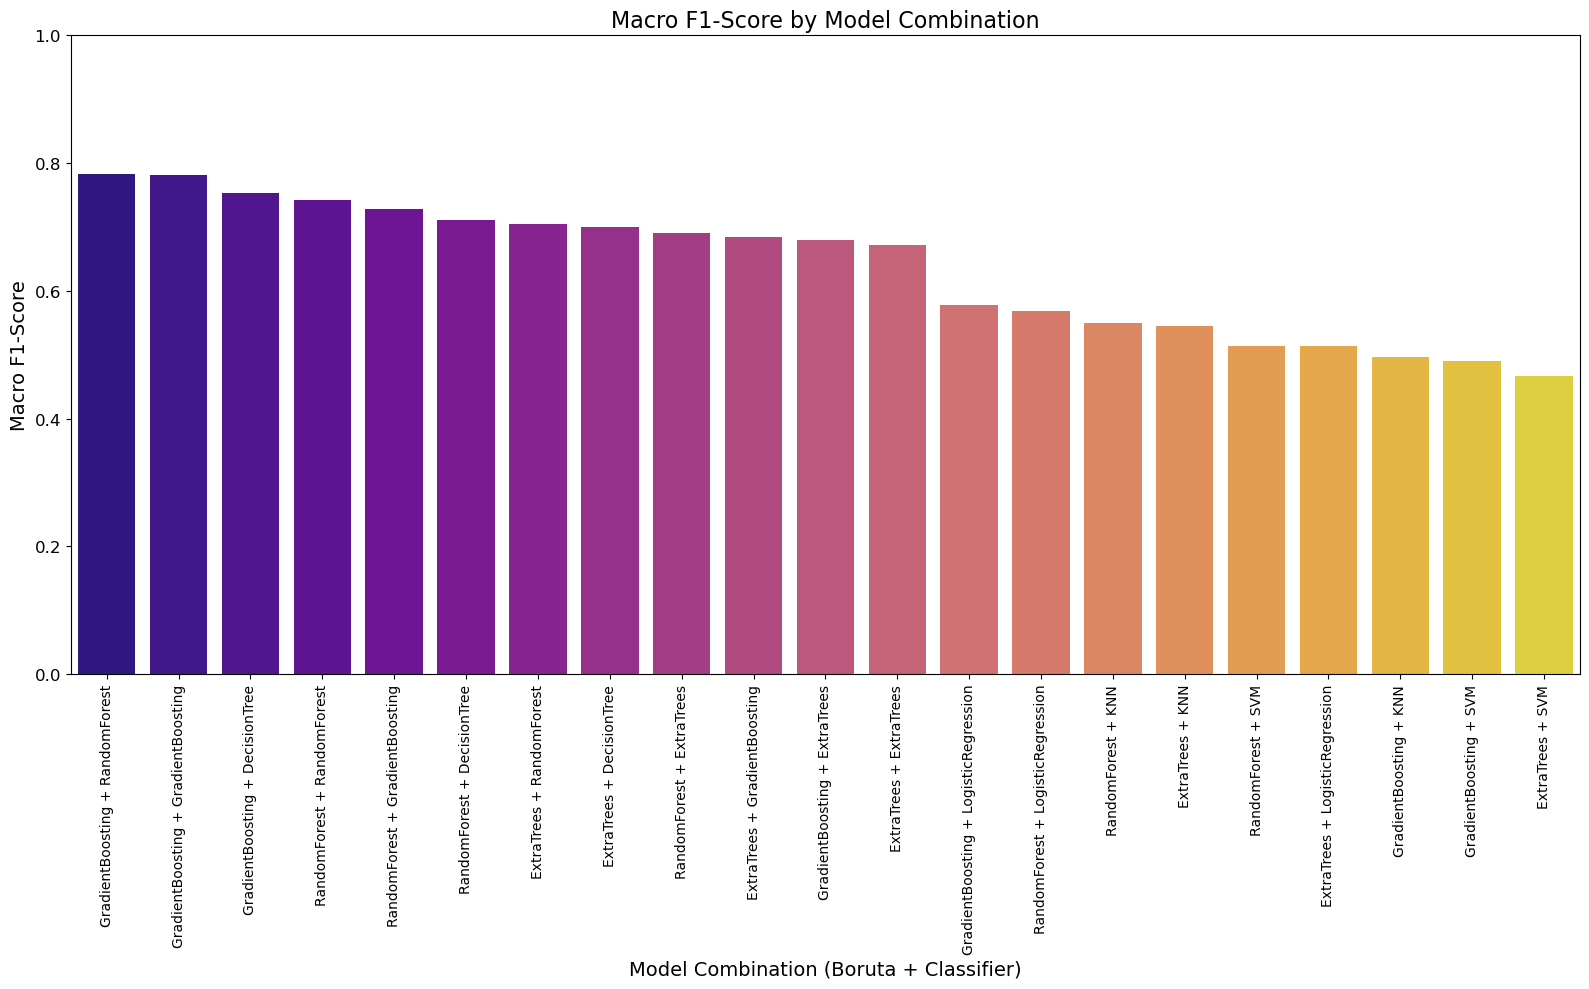

In [49]:
plot_f1_score_by_combination(df_results)

In [50]:
def plot_f1_score_vs_clusters(results_df):
    plt.figure(figsize=(8, 6))
    mean_scores = results_df.groupby("Num_Clusters")["Macro_F1_Score"].mean().reset_index()
    sns.lineplot(data=mean_scores, x="Num_Clusters", y="Macro_F1_Score", marker="o", color="blue", linewidth=2)
    plt.title("Impact of Number of Clusters on Macro F1-Score", fontsize=16)
    plt.ylabel("Average Macro F1-Score", fontsize=14)
    plt.xlabel("Number of Clusters", fontsize=14)
    plt.ylim(0, 1)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

In the following graph, the relationship between the number of clusters and the average macro F1-score is displayed. The performance remains relatively stable across the tested range of cluster numbers, with slight variations. This indicates that the choice of the number of clusters does not have a significant impact on the overall classification performance.

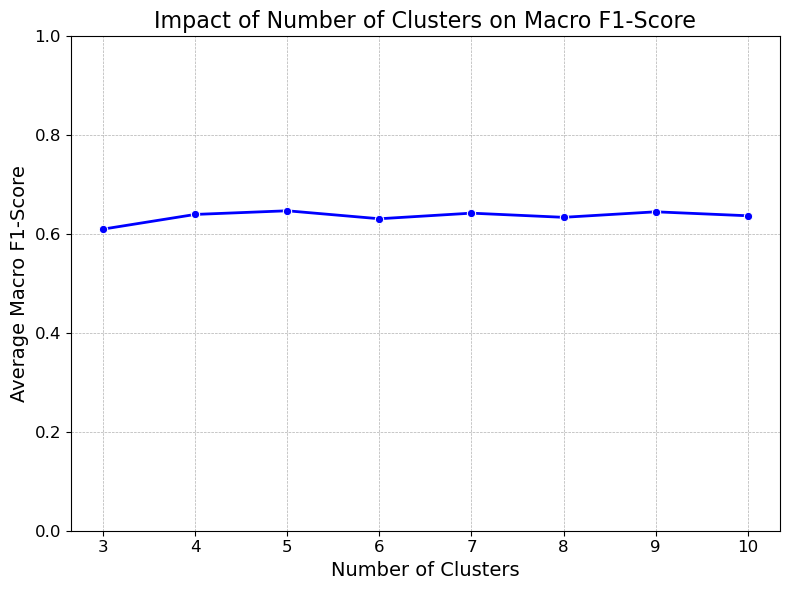

In [51]:
plot_f1_score_vs_clusters(df_results)

## Best model results

After testing several combinations of feature selection, clustering, and classification models, the following code identifies and displays the best-performing model on the test set. This includes the number of clusters, the feature selection method (Boruta model), the classification model, and the macro F1-score. Additionally, it outputs the classification report for the best model, providing detailed performance metrics for each class.

In [80]:
def display_classification_report(report_str):
    print(report_str.replace("\\n", "\n").strip("'"))

In [81]:
def display_best_model_info(df_results):
    best_model_row = df_results.iloc[df_results["Macro_F1_Score"].idxmax()]
    
    num_clusters = int(best_model_row["Num_Clusters"])
    classifier_model = best_model_row["Classifier_Model"]
    boruta_model = best_model_row["Boruta_Model"]
    macro_f1_score = best_model_row["Macro_F1_Score"]
    classification_report_str = best_model_row["Classification_Report"]
    
    print("Best Model Details:")
    print(f"Number of Clusters: {num_clusters}")
    print(f"Classifier Model: {classifier_model}")
    print(f"Boruta Model: {boruta_model}")
    print(f"Macro F1-Score: {macro_f1_score:.4f}")
    
    print("\nClassification Report:")
    display_classification_report(classification_report_str)

In [83]:
display_best_model_info(df_results)

Best Model Details:
Number of Clusters: 3
Classifier Model: RandomForest
Boruta Model: GradientBoosting
Macro F1-Score: 0.8189

Classification Report:
              precision    recall  f1-score   support

         HGG       0.90      0.98      0.94        58
         LGG       0.89      0.57      0.70        14

    accuracy                           0.90        72
   macro avg       0.90      0.78      0.82        72
weighted avg       0.90      0.90      0.89        72



### Best Model Analysis

The best-performing model identified from the optimization process has the following configuration:

- **Number of Clusters**: 3, indicating that the feature set was grouped into three clusters, with one representative feature selected from each.
- **Classifier Model**: RandomForest
- **Boruta Model**: GradientBoosting, which was used to identify the most relevant features before clustering,
- **Macro F1-Score**: 0.8189, reflecting the model's balanced performance across both classes.

### Classification Report Analysis

- **Class HGG**: The model achieves a high F1-score of 0.94, with precision at 0.90 and recall at 0.98. This indicates that the model is very effective at correctly classifying the majority class, with few false negatives.
- **Class LGG**: For the minority class, the F1-score is 0.70, with precision at 0.89 but a lower recall of 0.57. This suggests that while the model can identify many true LGG cases, it struggles to capture all instances, potentially due to class imbalance.

- **Overall Metrics**:
  - **Accuracy**: 0.90, showing that 90% of the test samples were correctly classified.
  - **Macro Average**: The macro F1-score of 0.82 highlights a reasonable balance between the two classes, although the performance is stronger for the majority class.
  - **Weighted Average**: The weighted F1-score of 0.89 reflects the overall performance while accounting for the class distribution.

### Insights

The model demonstrates strong performance overall, particularly for the majority class (HGG). However, the lower recall for the minority class (LGG) indicates room for improvement, potentially by employing techniques such as oversampling, class weighting, or other methods to address the class imbalance. The combination of GradientBoosting for feature selection and RandomForest for classification appears to be highly effective in this case.